In [2]:
import os
import glob  
import sys
from multiprocessing import Pool 
import time 
import numpy as np
import rasterio
import multiprocessing
import matplotlib.pyplot as plt
import xarray as xr
import dask
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cartopy.feature as cfeature

In [3]:
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')
print(mon_precip_sa)

<xarray.Dataset> Size: 66MB
Dimensions:    (date: 972, latitude: 141, longitude: 121)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 8kB 19400101 19400201 19400301 ... 20201101 20201201
  * latitude   (latitude) float64 1kB 0.0 -0.25 -0.5 ... -34.5 -34.75 -35.0
  * longitude  (longitude) float64 968B 10.0 10.25 10.5 ... 39.5 39.75 40.0
    expver     (date) <U4 16kB ...
Data variables:
    tp         (date, latitude, longitude) float32 66MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-11T20:12 GRIB to CDM+CF via cfgrib-0.9.1...


In [4]:
coarsened_precip = mon_precip_sa.coarsen(latitude=2, longitude=2, boundary='trim').mean()
coarsened_precip['date'] = pd.to_datetime(coarsened_precip['date'].values.astype(str), format='%Y%m%d')
print(coarsened_precip)

<xarray.Dataset> Size: 16MB
Dimensions:    (date: 972, latitude: 70, longitude: 60)
Coordinates:
    number     int64 8B 0
  * date       (date) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2020-12-01
  * latitude   (latitude) float64 560B -0.125 -0.625 -1.125 ... -34.12 -34.62
  * longitude  (longitude) float64 480B 10.12 10.62 11.12 ... 38.62 39.12 39.62
    expver     (date) <U4 16kB '0001' '0001' '0001' ... '0001' '0001' '0001'
Data variables:
    tp         (date, latitude, longitude) float32 16MB 0.007247 ... 0.002301
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-11T20:12 GRIB to CDM+CF via cfgrib-0.9.1...


In [5]:
mon_geopot_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_geopot_sa.nc')
print(mon_geopot_sa)

<xarray.Dataset> Size: 69MB
Dimensions:         (date: 1017, pressure_level: 1, latitude: 141,
                     longitude: 121)
Coordinates:
    number          int64 8B ...
  * date            (date) int64 8kB 19400101 19400201 ... 20240801 20240901
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 1kB 0.0 -0.25 -0.5 ... -34.5 -34.75 -35.0
  * longitude       (longitude) float64 968B 10.0 10.25 10.5 ... 39.5 39.75 40.0
    expver          (date) <U4 16kB ...
Data variables:
    z               (date, pressure_level, latitude, longitude) float32 69MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-13T13:22 GRIB to CDM+CF via cfgrib-0.9.1...


In [6]:
mon_geopot_sa['date'] = pd.to_datetime(mon_geopot_sa['date'].values.astype(str), format='%Y%m%d')
mon_geopot_sa = mon_geopot_sa.sel(date=slice(None, '2020-12-01'))
print(mon_geopot_sa)

<xarray.Dataset> Size: 66MB
Dimensions:         (date: 972, pressure_level: 1, latitude: 141, longitude: 121)
Coordinates:
    number          int64 8B ...
  * date            (date) datetime64[ns] 8kB 1940-01-01 ... 2020-12-01
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 1kB 0.0 -0.25 -0.5 ... -34.5 -34.75 -35.0
  * longitude       (longitude) float64 968B 10.0 10.25 10.5 ... 39.5 39.75 40.0
    expver          (date) <U4 16kB ...
Data variables:
    z               (date, pressure_level, latitude, longitude) float32 66MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-13T13:22 GRIB to CDM+CF via cfgrib-0.9.1...


In [7]:
o_f_geopot_sa = mon_geopot_sa.sel(date=(mon_geopot_sa['date.month'] >= 10) | (mon_geopot_sa['date.month'] <= 2))
print(o_f_geopot_sa)

<xarray.Dataset> Size: 28MB
Dimensions:         (date: 405, pressure_level: 1, latitude: 141, longitude: 121)
Coordinates:
    number          int64 8B ...
  * date            (date) datetime64[ns] 3kB 1940-01-01 ... 2020-12-01
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 1kB 0.0 -0.25 -0.5 ... -34.5 -34.75 -35.0
  * longitude       (longitude) float64 968B 10.0 10.25 10.5 ... 39.5 39.75 40.0
    expver          (date) <U4 6kB ...
Data variables:
    z               (date, pressure_level, latitude, longitude) float32 28MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-13T13:22 GRIB to CDM+CF via cfgrib-0.9.1...


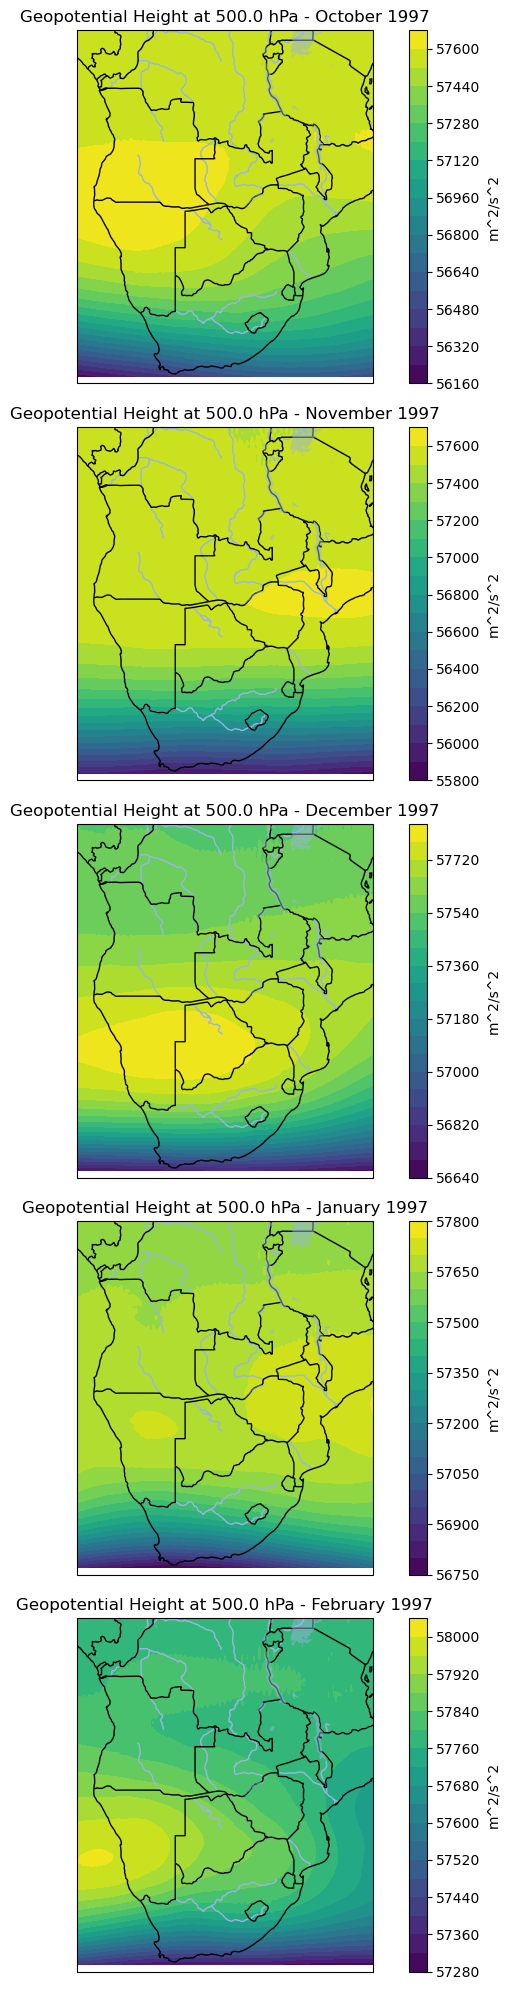

In [9]:
year_to_plot = 1997

# Filter for October to February for the specific year
filtered_data = o_f_geopot_sa.sel(date=slice(f'{year_to_plot}-10-01', f'{year_to_plot + 1}-02-01'))

# Specify the pressure level you want to plot (e.g., 500 hPa)
pressure_level = 500.0  
z_level = filtered_data.z.sel(pressure_level=pressure_level)

# Define months and their corresponding indices
months = ['October', 'November', 'December', 'January', 'February']
month_indices = [10, 11, 12, 1, 2]

# Create subplots
fig, axes = plt.subplots(len(months), 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.set_extent([10, 40, -35, 0])

# Loop through each month and plot
for i, month in enumerate(months):
    # Extract data for the specific month
    if i < 3:  # For October to December of the same year
        month_data = z_level.sel(date=z_level['date.month'] == month_indices[i])
    else:  # For January and February of the next year
        month_data = z_level.sel(date=z_level['date.month'] == month_indices[i])

    # Since we want data for a specific year, no need to average
    z_data = month_data.squeeze()  # This should result in 2D data (latitude, longitude)

    # Plot
    im = axes[i].contourf(month_data.longitude, month_data.latitude, z_data, 
                           levels=20, cmap='viridis', transform=ccrs.PlateCarree())
    axes[i].set_title(f'Geopotential Height at {pressure_level} hPa - {month} {year_to_plot}')
    axes[i].set_ylabel('Latitude')
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.02, pad=0.04, label = 'm^2/s^2')

# Set common xlabel
plt.xlabel('Longitude')
plt.tight_layout()
plt.show()

In [9]:
mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')
o_f_precip_sa = mon_precip_sa.sel(date=(mon_precip_sa['date.month'] >= 10) | (mon_precip_sa['date.month'] <= 2))

print(o_f_precip_sa)

<xarray.Dataset> Size: 28MB
Dimensions:    (date: 405, latitude: 141, longitude: 121)
Coordinates:
    number     int64 8B 0
  * date       (date) datetime64[ns] 3kB 1940-01-01 1940-02-01 ... 2020-12-01
  * latitude   (latitude) float64 1kB 0.0 -0.25 -0.5 ... -34.5 -34.75 -35.0
  * longitude  (longitude) float64 968B 10.0 10.25 10.5 ... 39.5 39.75 40.0
    expver     (date) <U4 6kB '0001' '0001' '0001' ... '0001' '0001' '0001'
Data variables:
    tp         (date, latitude, longitude) float32 28MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-11T20:12 GRIB to CDM+CF via cfgrib-0.9.1...


In [10]:
correlation = xr.corr(o_f_precip_sa['tp'], o_f_geopot_sa['z'], dim='date')
print(correlation)

<xarray.DataArray (latitude: 141, longitude: 121, pressure_level: 1)> Size: 68kB
array([[[ 0.02450673],
        [ 0.03722786],
        [ 0.04794773],
        ...,
        [ 0.06702064],
        [ 0.08044049],
        [ 0.09224611]],

       [[ 0.0370631 ],
        [ 0.05004194],
        [ 0.04218624],
        ...,
        [ 0.06237189],
        [ 0.07515412],
        [ 0.0873588 ]],

       [[ 0.07954673],
        [ 0.06373275],
        [ 0.05742551],
        ...,
...
        ...,
        [-0.18412662],
        [-0.18698768],
        [-0.17674187]],

       [[-0.38644847],
        [-0.3941709 ],
        [-0.40861863],
        ...,
        [-0.19914275],
        [-0.19987431],
        [-0.19301349]],

       [[-0.40560934],
        [-0.416226  ],
        [-0.42319822],
        ...,
        [-0.20847885],
        [-0.21039473],
        [-0.20643705]]], dtype=float32)
Coordinates:
    number          int64 8B 0
  * latitude        (latitude) float64 1kB 0.0 -0.25 -0.5 ... -34.5 -34.75 -35

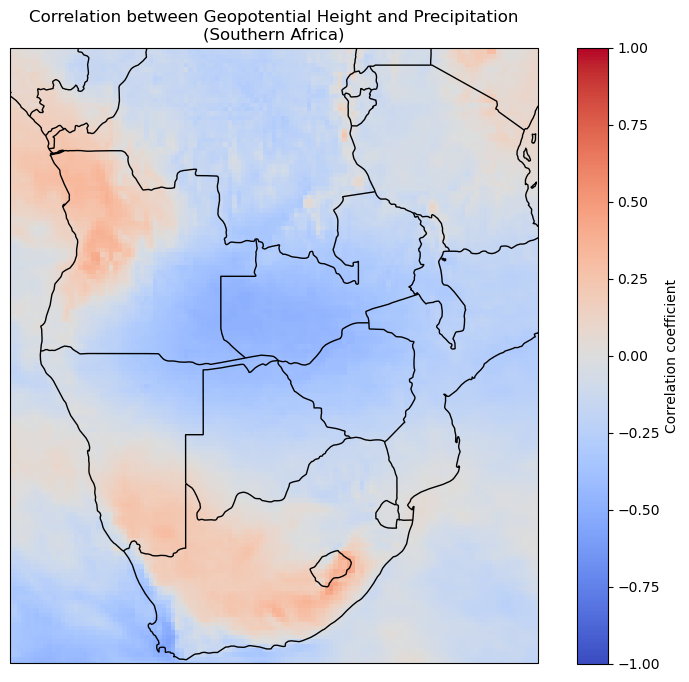

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([10, 40, -35, 0], crs=ccrs.PlateCarree())  # Southern Africa extent

# Add features like coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# Plot the correlation data
correlation.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1, cbar_kwargs={'label': 'Correlation coefficient'})

plt.title('Correlation between Geopotential Height and Precipitation\n(Southern Africa)')
plt.show()

In [15]:
lat_min, lat_max = -28, -12  
lon_min, lon_max = 17, 32

mon_precip_zambia = mon_precip_sa.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
mon_precip_zambia

winter_months = mon_precip_zambia.sel(time=ds['date.month'].isin([10, 11, 12, 1, 2]))

# Create a new coordinate for the winter season
winter_months['winter_season'] = winter_months['time.year'] + (winter_months['time.month'] >= 10).astype(int)

# Group by the winter season and sum the precipitation
seasonal_precip = winter_months.groupby('winter_season').sum(dim='time')

# Find the maximum seasonal precipitation
max_precip = seasonal_precip.max(dim='winter_season')


<xarray.Dataset> Size: 15MB
Dimensions:    (date: 972, latitude: 65, longitude: 61)
Coordinates:
    number     int64 8B 0
  * date       (date) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2020-12-01
  * latitude   (latitude) float64 520B -12.0 -12.25 -12.5 ... -27.5 -27.75 -28.0
  * longitude  (longitude) float64 488B 17.0 17.25 17.5 ... 31.5 31.75 32.0
    expver     (date) <U4 16kB '0001' '0001' '0001' ... '0001' '0001' '0001'
Data variables:
    tp         (date, latitude, longitude) float32 15MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-11T20:12 GRIB to CDM+CF via cfgrib-0.9.1...